In [1]:
from onboard.client import RtemClient
%run API_Key_Book.ipynb #Should be commented out and the line below run instead 
#client = RtemClient(api_key='YOUR_API_Key') #Should be used instead of line 2.

import pandas as pd
from onboard.client import OnboardClient
from onboard.client.dataframes import points_df_from_streaming_timeseries,df_time_index
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from datetime import datetime, timezone, timedelta
from typing import List
import pytz
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import linregress

In [2]:
def getSensorData(start,end,selection):
    timezone = pytz.timezone("America/New_York")
    start = timezone.localize(start)
    end = timezone.localize(end)

    timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
    sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))
    return sensor_data

def plotSensorData(sensor_data,title):
    sensor_data_clean = sensor_data.set_index('timestamp').astype(float).ffill()
    indexes = [i.split('T')[0] for i in list(sensor_data_clean.index)]
    sensor_data_clean.index = indexes
    fig = sensor_data_clean.plot(figsize=(15,8), fontsize = 12)
    fig.set_xlabel('time stamp',fontdict={'fontsize':15})
    fig.set_title(title)
    plt.show()
    
def fahrenheit_to_celsius(temp_in_F):
    return (temp_in_F - 32)*5/9

def celsius_to_fahrenheit(temp_in_C):
    return (temp_in_C*9/5) + 32

def compute_degreeday(temp, freq='MS', limit=65):
    degree_days = pd.DataFrame(None, columns=['HDD','CDD'], index=temp.index)
    degree_days.loc[:,'HDD'] = np.maximum( (limit - temp.resample('d').mean()),0 )
    degree_days.loc[:,'CDD'] = np.maximum( (temp.resample('d').mean() - limit),0 )
    return degree_days.resample(freq).sum().astype('int32')

def normalizedColumn(sensor_data,index):
    sensor_data['datetimeIndex'] = pd.to_datetime(sensor_data.iloc[:,0])    
    sensor_data = sensor_data.set_index('datetimeIndex')
    sample = sensor_data.loc[:,[index]]
    sample_days = sample.resample('m').sum()
    dateList = []
    temp = pd.DataFrame()
    for i in range(len(sample_days.index.values)):
        dateList.append(sample_days.index[i].strftime('%Y-%m-%d'))
    sample_days['newDate'] = pd.to_datetime(dateList) + timedelta(days=1) 
    sample_days = sample_days.set_index('newDate')
    sample_days = sample_days.join(deg_days)
    return pd.Series(sample_days.iloc[:,0] / (sample_days.iloc[:,1] + sample_days.iloc[:,2]))

def reglin(x, y):
    reg = linregress(x,y)
    return pd.Series((reg.intercept + x*reg.slope).to_numpy(), index=x),reg.rvalue**2, reg.pvalue

def plotElecVsHDDandCDD(sensor_data,index,name):
    sensor_data['datetimeIndex'] = pd.to_datetime(sensor_data.iloc[:,0])
    sensor_data = sensor_data.set_index('datetimeIndex')
    sample = sensor_data.loc[:,[index]]

    demand = sample.sum(axis=1).resample('MS').sum().rename('Demand') # Total demand on calendar month
    view = pd.concat([ deg_days.tz_localize(None), demand.tz_localize(None) ],axis=1).dropna(axis=0)
    colors = ['b','r','y','k','steelblue','lightgreen']

    fig,axes = plt.subplots(1,2,figsize=(16,4))
    for i,ax in enumerate(axes):
        for j,y in enumerate(view.index.year.unique()):
            view.loc[view.index.year==y,:].plot.scatter( x=view.columns[i], y='Demand', legend=False, ax=ax, color=colors[j] )
            if view.loc[view.index.year==y,:].shape[0]>1:
                reg,r2,p_value = reglin(view.loc[view.index.year==y,:].iloc[:,i], view.loc[view.index.year==y,'Demand'])
                reg.plot(ax=ax, color=colors[j], label=f"{y} ($R^2$={r2:.2f}, p={p_value:.2f})",legend=True)
        ax.set_title(f"Relation Electricity - {view.columns[i]}" + name,fontsize=14)
        ax.grid()
        ax.legend(loc=4)
    plt.tight_layout();

In [3]:
outside_temperature = pd.read_csv("./Temperatures_meteostats.csv",index_col=0,parse_dates=[0]).mean(axis=1) # Average out accross all stations

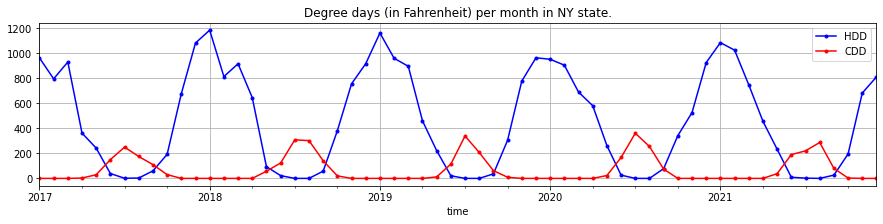

In [4]:
deg_days = compute_degreeday(celsius_to_fahrenheit(outside_temperature), limit=65, freq='MS')
deg_days.plot(figsize=(15,3), grid=True, marker='.', color=['b','r'], title="Degree days (in Fahrenheit) per month in NY state.")

## Electrification vs. HDD and CDD Graphs 

## Example with Building 419

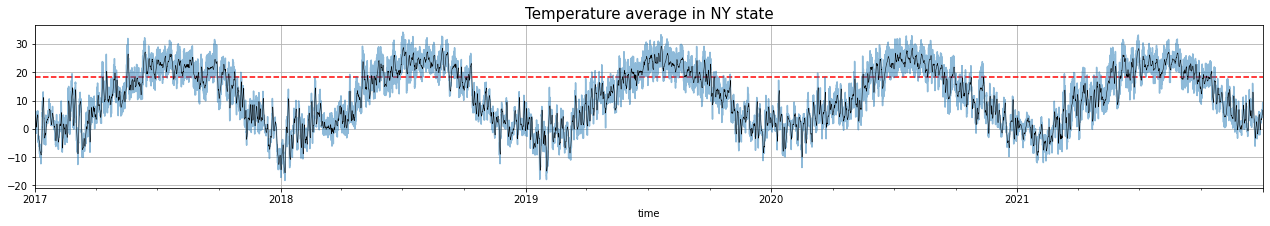

In [5]:
fig,ax = plt.subplots(1,1,figsize=(22,3))
outside_temperature.plot(ax=ax, alpha=.5)
outside_temperature.rolling(window=24).mean().plot(ax=ax, linewidth=.5, color='k')
ax.hlines(18+1/3, outside_temperature.index[0], outside_temperature.index[-1], linestyle='dashed', color='r')
ax.grid()
ax.set_title("Temperature average in NY state", fontsize=15);

## Building Example 122

In [6]:
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [122]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [122], 'equipment': [17799], 'equipment_types': [37], 'point_types': [178], 'points': [197125]}
1


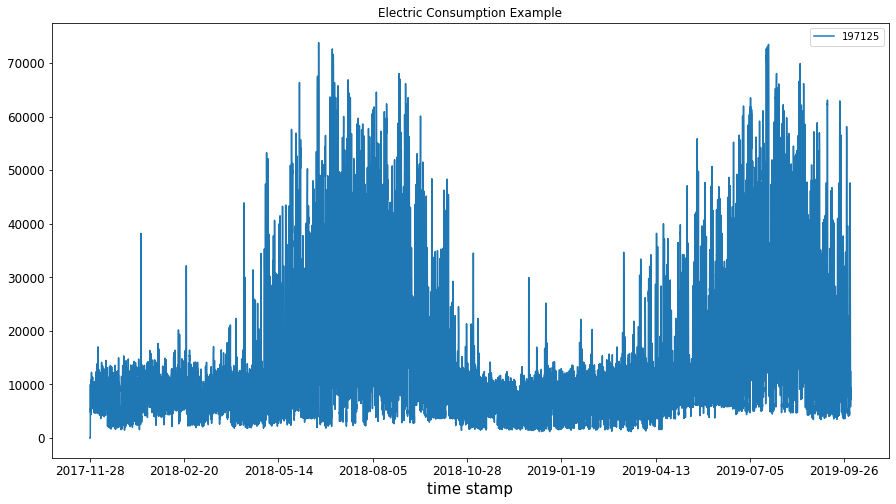

In [7]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


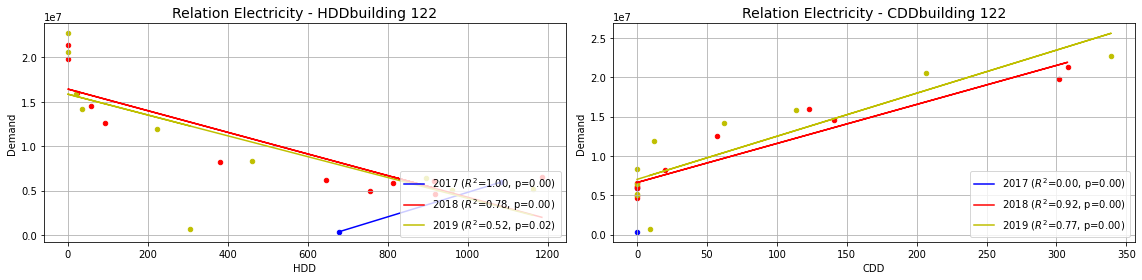

In [8]:
plotElecVsHDDandCDD(sensor_data,197125,"building 122")

In [9]:
normalized122 = normalizedColumn(sensor_data,197125)

## Building Example 105

In [10]:
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [105]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [105], 'equipment': [17264], 'equipment_types': [37], 'point_types': [178], 'points': [193812]}
1


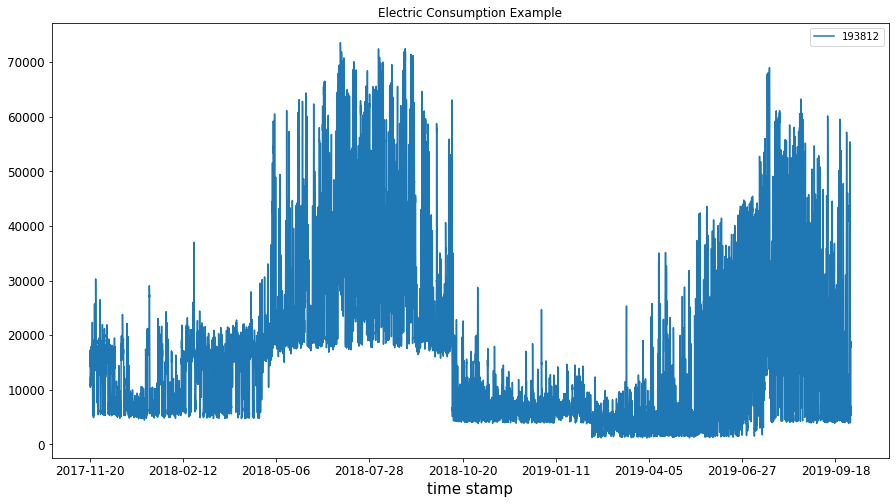

In [11]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


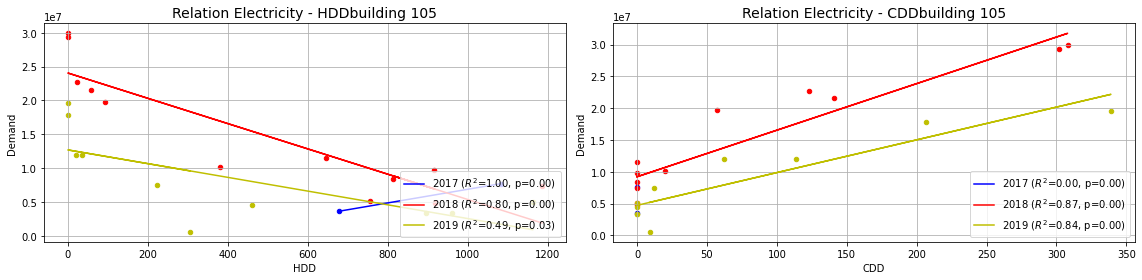

In [12]:
plotElecVsHDDandCDD(sensor_data,193812,"building 105")

In [13]:
normalized105 = normalizedColumn(sensor_data,193812)

## Building Example 115

In [14]:
# Set parameters for querying sensor data
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [115]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [115], 'equipment': [17385], 'equipment_types': [37], 'point_types': [178], 'points': [194260]}
1


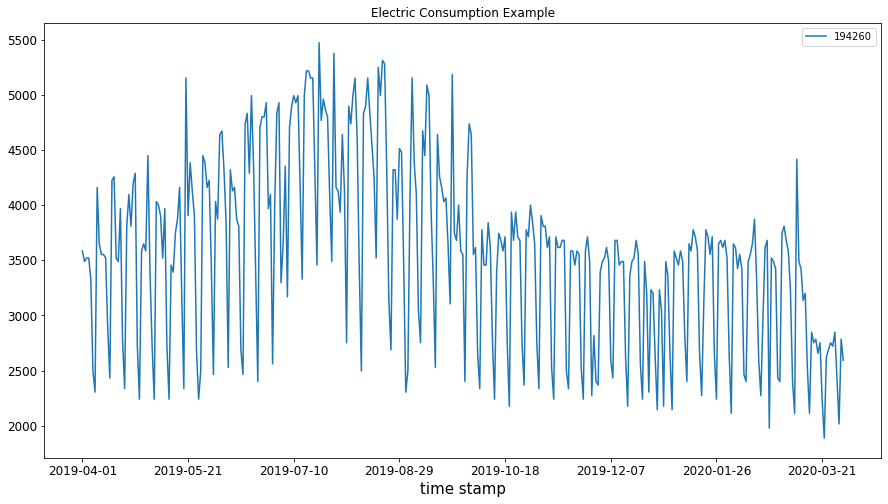

In [15]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:176: RuntimeWarning: divide by zero encountered in double_scalars
  slope_stderr = np.sqrt((1 - r**2) * ssym / ssxm / df)
/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:183: RuntimeWarning: invalid value encountered in double_scalars
  intercept_stderr = slope_stderr * np.sqrt(ssxm + xmean**2)


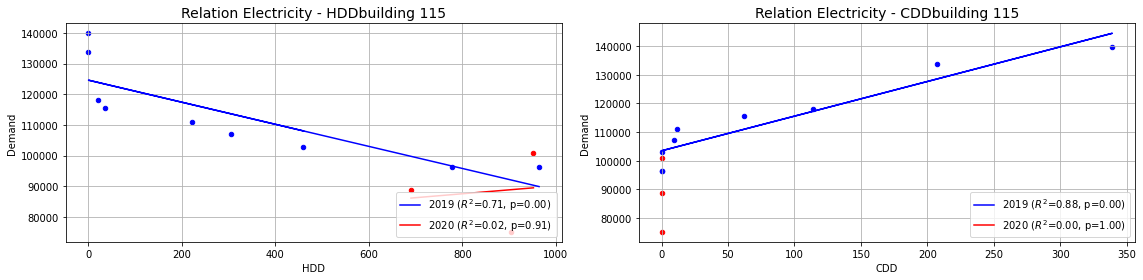

In [16]:
plotElecVsHDDandCDD(sensor_data,194260,"building 115")

In [17]:
normalized115 = normalizedColumn(sensor_data,194260)

## Building Example 179

In [18]:
# Set parameters for querying sensor data
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [179]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [179], 'equipment': [18606], 'equipment_types': [37], 'point_types': [178], 'points': [201363]}
1


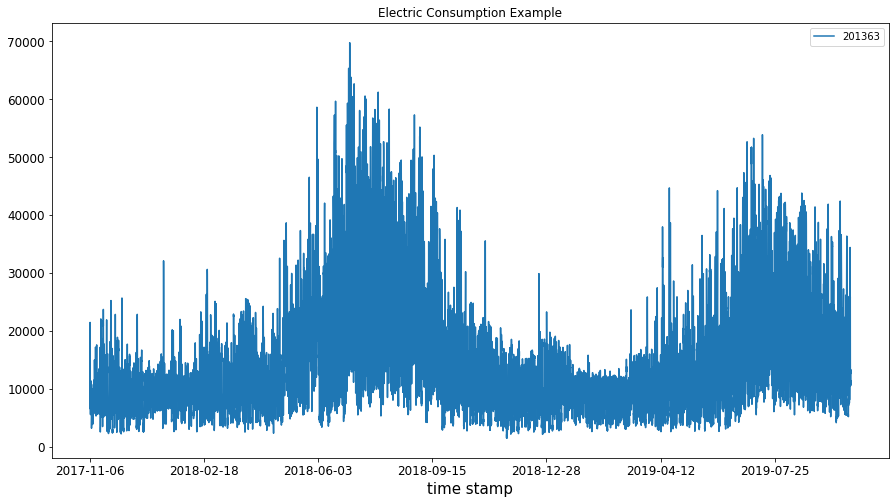

In [19]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:160: RuntimeWarning: invalid value encountered in double_scalars
  slope = ssxym / ssxm


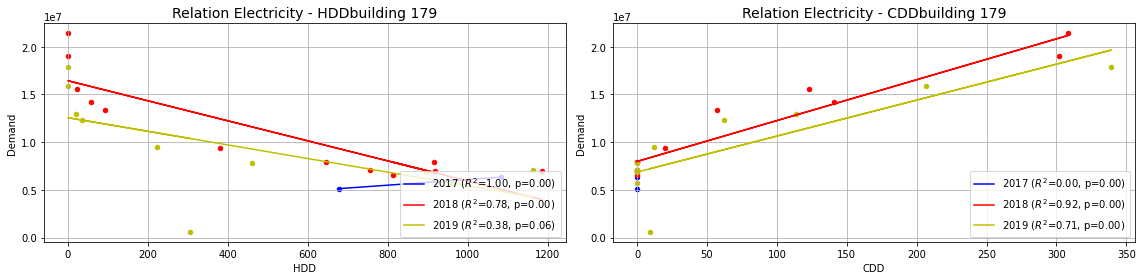

In [20]:
plotElecVsHDDandCDD(sensor_data,201363,"building 179")

In [21]:
normalized179 = normalizedColumn(sensor_data,201363)

## Building Example 307

In [22]:
# Set parameters for querying sensor data
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [307]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [307], 'equipment': [20842], 'equipment_types': [37], 'point_types': [178], 'points': [216705]}
1


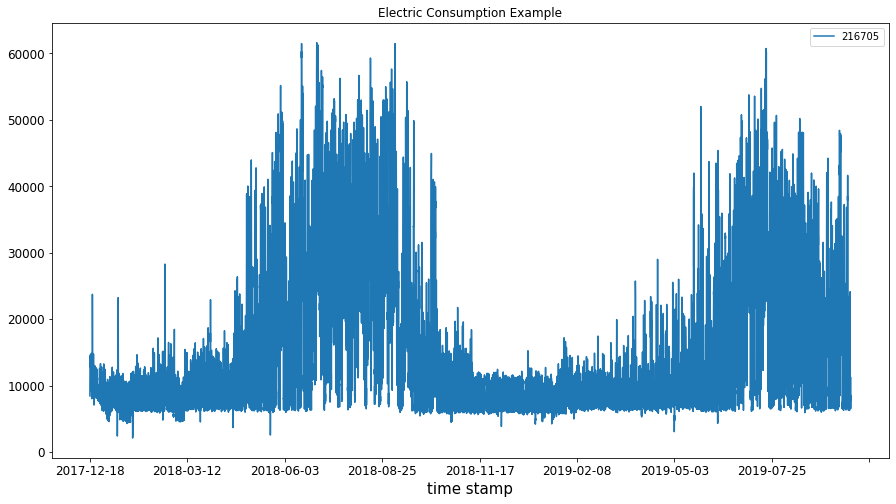

In [23]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

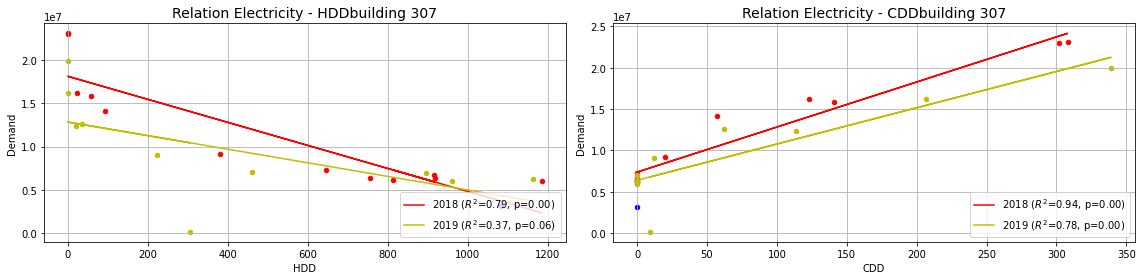

In [24]:
plotElecVsHDDandCDD(sensor_data,216705,"building 307")

In [25]:
normalized307 = normalizedColumn(sensor_data,216705)

## Building Example 157

In [26]:
# Set parameters for querying sensor data
query = PointSelector()
query.point_types     = ['Electric Consumption'] # can list multiple point types
query.equipment_types = ['site']
query.buildings = [157]

selection = client.select_points(query)
print(selection)
print(len(selection['equipment_types']))

{'orgs': [5], 'buildings': [157], 'equipment': [18267], 'equipment_types': [37], 'point_types': [178], 'points': [199219]}
1


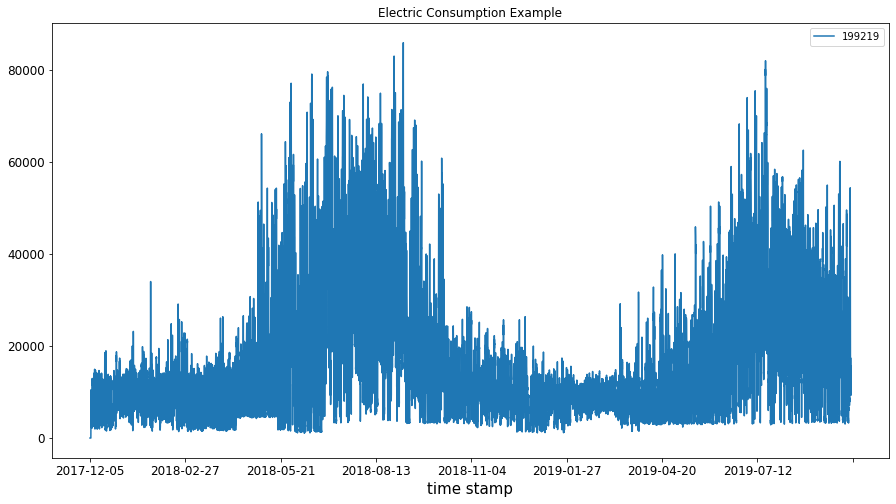

In [27]:
sensor_data = getSensorData(datetime(2017, 1, 22,00,00,00),datetime(2022, 1, 1,00,00,00),selection)
plotSensorData(sensor_data,"Electric Consumption Example")

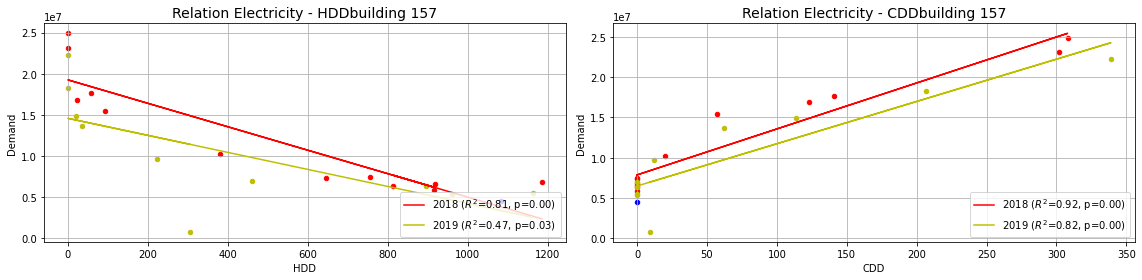

In [28]:
plotElecVsHDDandCDD(sensor_data,199219,"building 157")

In [29]:
normalized157 = normalizedColumn(sensor_data,199219)

In [30]:
normalizedColumns = pd.DataFrame()
normalizedColumns['Building 122'] = normalized122
normalizedColumns['Building 105'] = normalized105
normalizedColumns['Building 179'] = normalized179
normalizedColumns['Building 307'] = normalized307
normalizedColumns['Building 157'] = normalized157
normalizedColumns['Building 115'] = normalized115

In [31]:
print(normalizedColumns)

             Building 122   Building 105   Building 179   Building 307  \
newDate                                                                  
2017-12-01     328.278189    3338.443623    4741.109057            NaN   
2018-01-01    5014.075949    6493.731646    5344.332489    2675.800844   
2018-02-01    7992.114251    9120.061425    8608.058968    7384.183047   
2018-03-01    6416.913755    9136.638646    7194.160480    6742.351528   
2018-04-01    9358.123839   15103.650155   12192.509288   10376.962848   
2018-05-01   40835.119205   76062.629139   52170.966887   48456.662252   
2018-06-01   86632.786207  136110.034483   91960.027586   97427.000000   
2018-07-01   51961.902597   73645.792208   50582.042208   52633.262987   
2018-08-01   70675.314570   99090.039735   70868.384106   76429.986755   
2018-09-01   99381.442211  147311.809045   95594.246231  115527.693467   
2018-10-01   36288.112219   53895.775561   35480.461347   39486.643392   
2018-11-01   10943.064815   13432.1137

<Figure size 432x288 with 0 Axes>

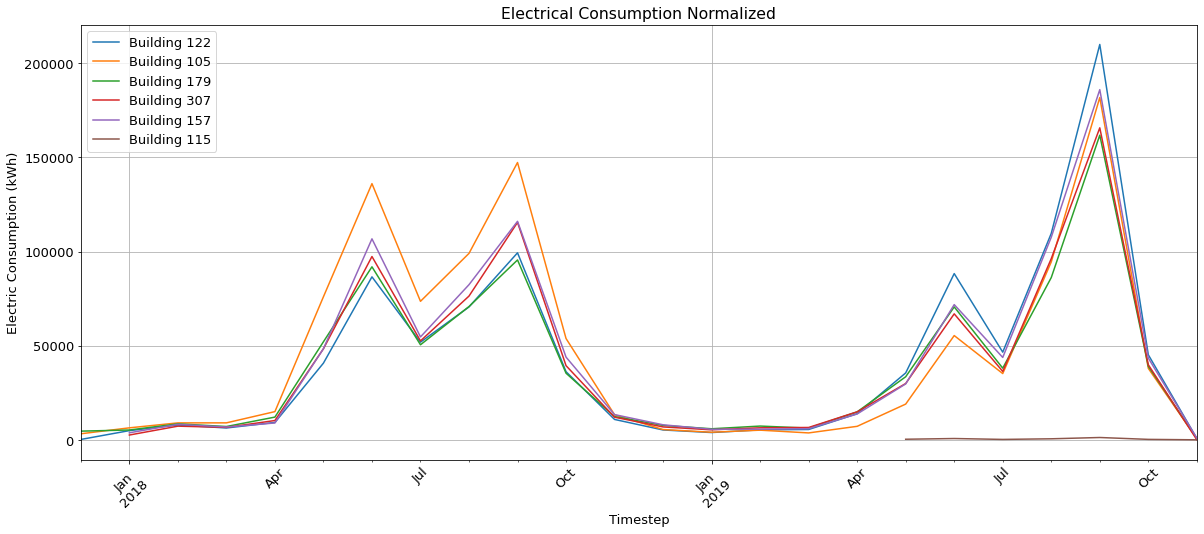

In [32]:
plt.figure()
plt.rcParams.update({'font.size': 13}) 
normalizedColumns.plot(figsize = (20,8),title = 'Electrical Consumption Normalized',rot = 45,grid = True,fontsize = 13,
                      ylabel = 'Electric Consumption (kWh)',xlabel = 'Timestep')